<p><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" align="left" hspace="50px" vspace="0px" style="width:107px;height:152px;"></p>
<h1><font color='#FFFFFFF'> <center>
Proyecto 4</center></font></h1>
<h2><font color='#FFFFFFF'> <center>
Proyecto 2024-02 </center></font></h2>
<h3><font color='#FFFFFFF'> <center>María J. Ostos - Cristian Florez - Juan A. Sañudo</center></font></h3>
<h3><font color='#FFFFFFF'> <center>
2024 </center></font></h3>
<font  face="Courier New" size="3">
<p1><center> </center></p1>

1. Revisión teórica. Del artículo:
https://www.nature.com/articles/s41598-020-59821-7

Hacer un resumen de la sección extracción de caracteríticas (Features extraction) y discutir desde el artículo u otras referencias como se hace cuando desaparecen ciertas formas de ondas en el complejo PQRS debido a alguna enfermedad (10%)

----

Este proyecto propone un método innovador y comprensible para la extracción de características a partir de señales ECG (electrocardiograma) con el fin de evaluar diferentes esquemas de clasificación de múltiples etapas. Se analizaron etapas distintas de selección de características, comenzando con un conjunto básico de 11 variables hasta alcanzar un conjunto exhaustivo de 39.830 variables. Se incluyeron variables como la edad y el género debido a su relevancia en el análisis médico, además de la media y varianza de los intervalos RR calculados en la derivación II del ECG.
Se definieron seis grupos de características, destacando los siguientes:
Grupo 1: 11 variables básicas del ECG como la frecuencia ventricular y auricular, duración del QRS, intervalo QT, ejes R y T.
Grupo 2: 23 variables relacionadas con la media y varianza de los intervalos RR, y medidas del complejo QRS (altura, ancho, prominencia).
Análisis exhaustivo de 900 frecuencias de altura, ancho y prominencia, 600 frecuencias de diferencias de ubicación y 1800 frecuencias de relaciones ancho/tiempo, altura/tiempo y prominencia/tiempo.
Los picos y valles del ECG se clasificaron en tres subconjuntos: complejo QRS, picos no QRS y valles. Se analizaron seis combinaciones de pares para medir las relaciones entre ancho, altura y prominencia frente al tiempo. Debido a la variabilidad de estas relaciones entre pacientes, se construyeron tablas de distribución de frecuencia empírica con 100 grupos, garantizando una entrada uniforme para el modelo de clasificación.
El método propuesto permite revelar completamente la distribución de frecuencia empírica de los segmentos P, Q, R, S y T, lo cual es clave para la identificación de ritmos cardíacos. Las pruebas realizadas demostraron que esta estrategia es confiable y robusta, favoreciendo una mejor clasificación de los ritmos cardíacos.
En la clasificación de arritmias mediante ECG, uno de los desafíos es la variabilidad morfológica de las ondas P, Q, R, S y T debido a factores como la edad, género, raza y condiciones cardíacas. Las arritmias pueden distorsionar u omitir completamente ciertas ondas, dificultando su detección. Las técnicas tradicionales, como la Transformada de Fourier o Wavelet, tienden a ignorar la información temporal, lo que limita la precisión.
Para abordar esto, se propone reescalar las señales ECG mediante el algoritmo de máximo-mínimo, que ajusta todas las amplitudes a un rango uniforme, permitiendo comparar señales de distintos pacientes en condiciones homogéneas. Además, el uso de redes neuronales, combinando características del dominio del tiempo y la frecuencia, mejora significativamente la clasificación de arritmias complejas.
Además, existen técnicas médicas que ya identifican que patologías generan desapariciones o cambios en la señal ECG, por lo que entrenar redes neuronales con cierta información ayuda a explicar la ausencia de segmentos propios del ECG

![Img_1](./Img_1.jpg)


---

2. Base de datos. Del proyecto pasado hay dos opciones de base de datos, la filtrada por los autores o la filtrada en el proyecto 3. De acuerdo a los resultados del proyecto 3 usar la mejor base de datos y justificar la selección
De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx De estos registros los análisis para el presente proyecto deben hacerse en la derivación II

### Carga de librerias

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.signal import detrend, welch, butter, filtfilt
import pywt
import random
import warnings
import neurokit2 as nk
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.utils import to_categorical
#MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#CNN
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

#LSTM
from tensorflow.keras.layers import LSTM

warnings.filterwarnings("ignore", category=UserWarning)  # Para warnings de tipo UserWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)  # Para warnings de tipo RuntimeWarning
warnings.filterwarnings("ignore", category=FutureWarning)  # Para warnings de tipo FutureWarning

### Carga de datos Diagnostics.xlsx

In [121]:
fs=500

# ruta_diagnostics= r"C:\Users\Lenovo a9 w10\Documents\LabBiosenales\Proyecto_2/Diagnostics.xlsx"
ruta_diagnostics="../Proyecto_3/datos/Diagnostics.xlsx"
df_diagnostics = pd.read_excel(ruta_diagnostics)

# Crear el nuevo dataframe filtrando por la columna 'Rhythm'
datos_diagnostics = df_diagnostics[(df_diagnostics['Rhythm'] == 'SB') | (df_diagnostics['Rhythm'] == 'AFIB')]

#Tamaño del nuevo dataframe
datos_diagnostics.shape

tiempo_diagnostics = np.arange(0, datos_diagnostics.shape[0]/fs,1/fs)

datos_diagnostics.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
5,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395


In [3]:
datos_diagnostics.columns

Index(['FileName', 'Rhythm', 'Beat', 'PatientAge', 'Gender', 'VentricularRate',
       'AtrialRate', 'QRSDuration', 'QTInterval', 'QTCorrected', 'RAxis',
       'TAxis', 'QRSCount', 'QOnset', 'QOffset', 'TOffset'],
      dtype='object')

In [122]:
# Separar nombres de archivo en listas según el ritmo 'SB' y 'AFIB'
sb_files = datos_diagnostics[datos_diagnostics['Rhythm'] == 'SB']['FileName'].tolist()
afib_files = datos_diagnostics[datos_diagnostics['Rhythm'] == 'AFIB']['FileName'].tolist()

In [123]:
def cargar_datos(selected_files,ruta): #Ruta 1 sin filtrar, 2 para filtrados
    # Diccionario para almacenar cada DataFrame y su columna 'II'
    data_frames = {}
    datos_II = {}
    
    # Iterar sobre los archivos en la lista
    for i, file in enumerate(selected_files):
        if ruta==1:
            df = pd.read_csv(f"../Proyecto_3/datos/ECGData/ECGData/{file}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
        elif ruta==2:
            df = pd.read_csv(f"../Proyecto_3/datos/ECGDataDenoised/{file}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
        data_frames[f"df{i+1}"] = df
        # datos_II[f"datos_f{i+1}"] = df["II"]
        datos_II[f"{file}"] = df["II"]
    
    return data_frames, datos_II


3. Herramientas computacionales. Hacer un minitutorial del uso de la herramienta NeuroKit (https://neuropsychology.github.io/NeuroKit/index.html) orientado al análisis de señales ECG (10%)

Tutoria se encuentra en el archivo Neurokit.ipynb

4. Escoger diferentes señales de la base de datos del punto 2 y aplicar el tutorial del punto 3 (5%).

In [124]:
## Codigo para pruebas con n sujetos

# Número total de archivos a seleccionar
n_seleccion = 5

# Calcular la mitad para cada ritmo (o una distribución casi mitad y mitad si n_seleccion es impar)
n_sb = n_seleccion // 2
n_afib = n_seleccion - n_sb

# Seleccionar aleatoriamente el número calculado de archivos de cada tipo
selected_sb_files = random.sample(sb_files, min(n_sb, len(sb_files)))
selected_afib_files = random.sample(afib_files, min(n_afib, len(afib_files)))

# Combinar las selecciones de 'SB' y 'AFIB' en la lista final
selected_files = selected_sb_files + selected_afib_files

# Mezclar los archivos seleccionados para no tener un orden específico de 'SB' o 'AFIB'
random.shuffle(selected_files)
# Filtrar el DataFrame para obtener solo las filas de los archivos en selected_files
selected_data = datos_diagnostics[datos_diagnostics['FileName'].isin(selected_files)]

# Crear un diccionario con 'FileName' como clave y 'Rhythm' como valor para fácil acceso
file_rhythm_dict = dict(zip(selected_data['FileName'], selected_data['Rhythm']))

In [125]:
#Se cargan los datos
all_files = datos_diagnostics['FileName'].tolist()
dfs1,datos_II_ecg=cargar_datos(selected_files,1)
sujetos=datos_II_ecg.keys()




In [126]:
sujetos

dict_keys(['MUSE_20180118_133117_13000', 'MUSE_20180113_184000_10000', 'MUSE_20180112_075225_59000', 'MUSE_20180116_120804_20000', 'MUSE_20180118_172418_35000'])

In [127]:
# Filtrar el DataFrame para obtener solo las filas de los archivos en selected_files
selected_data_all = datos_diagnostics[datos_diagnostics['FileName'].isin(all_files)]

# Crear un diccionario con 'FileName' como clave y 'Rhythm' como valor para fácil acceso
file_rhythm_all = dict(zip(selected_data_all['FileName'], selected_data_all['Rhythm']))


In [130]:

# for archivo in all_files:
for archivo in sujetos:
    dato=datos_II_ecg[archivo][1:].astype(float)  # Convertir a tipo numérico si es necesario
    print(f'Sujeto {archivo}')
    # Procesar la señal ECG
    Processed_signals, info = nk.ecg_process(dato, sampling_rate=500)

    # Extraer los picos R de la señal ECG y obtener promedio para obtener la frecuencia ventricular
    picos_R = info['ECG_R_Peaks']
    # Calcular los intervalos RR (en segundos) dividiendo por la frecuencia de muestreo
    intervalos_RR = np.diff(picos_R) / fs
    # Calcular la frecuencia ventricular promedio (latidos por minuto)
    VentricularRate  = 60 / np.mean(intervalos_RR)
    print(f'Frecuencia ventricular promedio: {VentricularRate}')

    # Extraer los picos P de la señal ECG
    picos_P = np.array(info['ECG_P_Peaks'])
    # Filtrar NaN de los picos P para evitar errores de cálculo
    # picos_P_limpios = picos_P[~np.isnan(picos_P)]
    picos_P_limpios = pd.Series(picos_P).interpolate().values #se cambian los NaN interpolandolos. Esto es útil para señales fisiológicas, ya que los datos suelen ser continuos.
    # Calcular la frecuencia auricular promedio (latidos por minuto)
    AtrialRate = 60 / np.mean(np.diff(picos_P_limpios) / 500)
    print(f'frecuencia auricular promedio: {AtrialRate}')

    # Cantidad de complejos QRS
    QRSCount = len(picos_R)  
    print(f'Cantidad de complejos QRS: {QRSCount}')
    
    # Extraer las fases ventriculares (sístole y diástole)
    fases_ventriculares = Processed_signals["ECG_Phase_Ventricular"].values
    # Contar las muestras en cada fase
    conteo_sistole = len(fases_ventriculares[fases_ventriculares == 1])
    conteo_diastole = len(fases_ventriculares[fases_ventriculares == 0])
    # Duración promedio de cada fase
    systole_duration = conteo_sistole / fs  # En segundos
    diastole_duration = conteo_diastole / fs  # En segundos
    print(f'Duración promedio de sistole={systole_duration} y de diastole={diastole_duration}')

    # Relación sístole/diástole
    if diastole_duration==0:
        systole_diastole_ratio = "NaN"
    else:
        systole_diastole_ratio = systole_duration / diastole_duration
        print(f'Relación entre sistole y diastole: {systole_diastole_ratio}')
    
    print("\n")

Sujeto MUSE_20180118_133117_13000
Frecuencia ventricular promedio: 64.9772579597141
frecuencia auricular promedio: 65.24575902566332
Cantidad de complejos QRS: 11
Duración promedio de sistole=3.554 y de diastole=5.682
Relación entre sistole y diastole: 0.6254839845124955


Sujeto MUSE_20180113_184000_10000
Frecuencia ventricular promedio: 54.91990846681923
frecuencia auricular promedio: 56.32480638347807
Cantidad de complejos QRS: 9
Duración promedio de sistole=3.25 y de diastole=5.492
Relación entre sistole y diastole: 0.5917698470502549


Sujeto MUSE_20180112_075225_59000
Frecuencia ventricular promedio: 58.06919912896201
frecuencia auricular promedio: 56.59042678613535
Cantidad de complejos QRS: 9
Duración promedio de sistole=3.188 y de diastole=5.452
Relación entre sistole y diastole: 0.5847395451210565


Sujeto MUSE_20180116_120804_20000
Frecuencia ventricular promedio: 95.151789759855
frecuencia auricular promedio: 96.26403850561537
Cantidad de complejos QRS: 15
Duración promedio

5. Con las características que extrae el neurokit y las discutidas en el punto 1 generar un conjunto de características para el presente trabajo. Incluir la característica de frecuencia de potencia máxima del Proyecto 3 (10%). No incluir más de 15 características ni menos de 5, justificar la selección (5%).

In [6]:
#Para todos los datos
all_files = datos_diagnostics['FileName'].tolist()
df,datos_II_ecg=cargar_datos(all_files,1)
sujetos=datos_II_ecg.keys()


In [7]:
sujetos

dict_keys(['MUSE_20180113_171327_27000', 'MUSE_20180112_073319_29000', 'MUSE_20180113_121940_44000', 'MUSE_20180112_120347_79000', 'MUSE_20180114_075026_69000', 'MUSE_20180114_075128_92000', 'MUSE_20180118_174026_42000', 'MUSE_20180115_125443_25000', 'MUSE_20180113_134825_04000', 'MUSE_20180114_070718_20000', 'MUSE_20180115_133559_70000', 'MUSE_20180113_133901_16000', 'MUSE_20180113_071734_35000', 'MUSE_20180114_121218_64000', 'MUSE_20180113_075301_94000', 'MUSE_20180114_122918_82000', 'MUSE_20180118_135246_80000', 'MUSE_20180116_123940_90000', 'MUSE_20180118_132124_94000', 'MUSE_20180118_134426_93000', 'MUSE_20180116_130527_79000', 'MUSE_20180114_075003_61000', 'MUSE_20180113_131417_18000', 'MUSE_20180116_124959_22000', 'MUSE_20180114_073026_18000', 'MUSE_20180113_074740_85000', 'MUSE_20180116_132201_77000', 'MUSE_20180114_132044_36000', 'MUSE_20180115_124515_42000', 'MUSE_20180116_131337_59000', 'MUSE_20180113_183351_27000', 'MUSE_20180114_072951_09000', 'MUSE_20180113_172948_90000',

In [12]:
# Filtrar el DataFrame para obtener solo las filas de los archivos en selected_files
selected_data_all = datos_diagnostics[datos_diagnostics['FileName'].isin(all_files)]

# Crear un diccionario con 'FileName' como clave y 'Rhythm' como valor para fácil acceso
file_rhythm_all = dict(zip(selected_data_all['FileName'], selected_data_all['Rhythm']))

df_ECG = pd.DataFrame(columns=["Registro", "Estado","VentricularRate","AtrialRate","QRSCount","systole_duration","diastole_duration","systole_diastole_ratio"])
# df_ECG = pd.DataFrame(columns=["Registro", "Estado","VentricularRate","AtrialRate","QRSCount","QRSDuration","QTInterval","qt_corrected","systole_duration","diastole_duration","systole_diastole_ratio"])


In [23]:
for archivo in sujetos:
    try:
        # Convertir a tipo numérico si es necesario y manejar NaN
        dato = datos_II_ecg[archivo][1:].astype(float).interpolate().fillna(method='bfill').fillna(method='ffill')
        
        # Procesar la señal ECG
        Processed_signals, info = nk.ecg_process(dato, sampling_rate=fs)
        
        # Calcular los picos R y manejar errores
        picos_R = info.get('ECG_R_Peaks', [])
        if len(picos_R) < 2:
            raise ValueError("No se detectaron suficientes picos R para calcular la frecuencia ventricular.")
        intervalos_RR = np.diff(picos_R) / fs
        VentricularRate = 60 / np.mean(intervalos_RR) if len(intervalos_RR) > 0 else np.nan
        
        # Calcular los picos P y manejar errores
        picos_P = info.get('ECG_P_Peaks', [])
        if len(picos_P) < 2:
            AtrialRate = np.nan
        else:
            picos_P = pd.Series(picos_P).interpolate().fillna(np.nan).values
            intervalos_P = np.diff(picos_P) / fs
            AtrialRate = 60 / np.mean(intervalos_P) if len(intervalos_P) > 0 else np.nan

        # Calcular la cantidad de complejos QRS
        QRSCount = len(picos_R)
        
        # Calcular la duración promedio del QRS
        Q_onsets = np.array(info.get("ECG_Q_Peaks", []))
        Q_offsets = np.array(info.get("ECG_R_Offsets", []))
        if len(Q_onsets) > 0 and len(Q_offsets) > 0:
            QRS_durations = (Q_offsets - Q_onsets) / fs
            QRSDuration = np.mean(QRS_durations)
        else:
            QRSDuration = np.nan
        
        # Calcular el intervalo QT y el QT corregido
        T_offsets = np.array(info.get("ECG_T_Offsets", []))
        if len(Q_onsets) > 0 and len(T_offsets) > 0:
            QT_intervals = (T_offsets - Q_onsets) / fs
            QTInterval = np.mean(QT_intervals)
            qt_corrected = QTInterval / np.sqrt(np.mean(intervalos_RR)) if len(intervalos_RR) > 0 else np.nan
        else:
            QTInterval = np.nan
            qt_corrected = np.nan
        
        # Calcular las fases ventriculares
        fases_ventriculares = Processed_signals["ECG_Phase_Ventricular"].values
        conteo_sistole = len(fases_ventriculares[fases_ventriculares == 1])
        conteo_diastole = len(fases_ventriculares[fases_ventriculares == 0])
        systole_duration = conteo_sistole / fs if conteo_sistole > 0 else np.nan
        diastole_duration = conteo_diastole / fs if conteo_diastole > 0 else np.nan
        systole_diastole_ratio = systole_duration / diastole_duration if diastole_duration > 0 else np.nan
    
    except Exception as e:
        # Manejar errores asignando NaN a todas las variables
        print(f"Error procesando el archivo {archivo}: {e}")
        VentricularRate = AtrialRate = QRSCount = QRSDuration = QTInterval = qt_corrected = systole_duration = diastole_duration = systole_diastole_ratio = np.nan
    
    # Guardar los resultados en el DataFrame
    nombre_sujeto = archivo[:-4]  # Nombre del sujeto (sin extensión .csv)
    estado = file_rhythm_all.get(archivo, "Unknown")  # Estado del sujeto
    
    df_ECG = pd.concat([
        df_ECG,
        pd.DataFrame({
            'Registro': [nombre_sujeto],
            'Estado': [estado],
            "VentricularRate": [VentricularRate],
            "AtrialRate": [AtrialRate],
            "QRSCount": [QRSCount],
            "QRSDuration": [QRSDuration],
            "QTInterval": [QTInterval],
            "qt_corrected": [qt_corrected],
            "systole_duration": [systole_duration],
            "diastole_duration": [diastole_duration],
            "systole_diastole_ratio": [systole_diastole_ratio]
        })
    ], ignore_index=True)

# print(df_ECG)


Error procesando el archivo MUSE_20180114_071341_77000: operands could not be broadcast together with shapes (10,) (9,) 
Error procesando el archivo MUSE_20180113_121039_40000: cannot convert float NaN to integer
Error procesando el archivo MUSE_20180114_124930_50000: cannot convert float NaN to integer
Error procesando el archivo MUSE_20180116_173718_14000: integer division or modulo by zero
                     Registro Estado  VentricularRate  AtrialRate QRSCount  \
0      MUSE_20180113_171327_2   AFIB       117.085863         NaN       19   
1      MUSE_20180112_073319_2     SB        51.698671   51.673228        8   
2      MUSE_20180113_121940_4     SB        53.309640   53.297801        9   
3      MUSE_20180112_120347_7     SB        56.617127   56.590427        9   
4      MUSE_20180114_075026_6   AFIB        95.703956   95.379398       16   
...                       ...    ...              ...         ...      ...   
11489  MUSE_20180114_134724_1     SB        56.035489   56

In [ ]:
df_ECG.drop(["QRSDuration"], axis=1, inplace=True)
df_ECG.drop(["QTInterval"], axis=1, inplace=True)
df_ECG.drop(["qt_corrected"], axis=1, inplace=True)

In [60]:
df_ECG.head()

,Registro,Estado,VentricularRate,AtrialRate,QRSCount,systole_duration,diastole_duration,systole_diastole_ratio
0,MUSE_20180113_171327_2,AFIB,117.085863,NaN,19.0,2.930,6.492,0.451325
1,MUSE_20180112_073319_2,SB,51.698671,51.673228,8.0,2.978,5.518,0.539688
2,MUSE_20180113_121940_4,SB,53.309640,53.297801,9.0,3.170,5.836,0.543180
3,MUSE_20180112_120347_7,SB,56.617127,56.590427,9.0,3.126,5.698,0.548614
4,MUSE_20180114_075026_6,AFIB,95.703956,95.379398,16.0,4.508,4.898,0.920376


In [52]:
df_ECG.columns

Index(['Registro', 'Estado', 'VentricularRate', 'AtrialRate', 'QRSCount',
       'systole_duration', 'diastole_duration', 'systole_diastole_ratio',
       'QRSDuration', 'QTInterval', 'qt_corrected'],
      dtype='object')

In [ ]:
# df_ECG.to_excel("Dataframe_ecg.xlsx", index=False)

6. Crear una rutina que aplique sobre todos los archivos de la base de datos la rutina 5 y almacene los resultados en un dataframe:

In [105]:
ruta_base_datos_p3="./datos/Dataframe_P3.xlsx"
df_p3 = pd.read_excel(ruta_base_datos_p3)

In [106]:
datos_diagnostics = datos_diagnostics.rename(columns={'FileName': 'Registro'})

In [107]:
df_diagnostics_2merge= datos_diagnostics[["Registro","Beat","PatientAge","Gender"]]
df_p3_2merge= df_p3[["Registro","fMP"]]

In [109]:
df_diagnostics_2merge['Registro'] = df_diagnostics_2merge['Registro'].str.replace(r'_(\d*?)0+$', r'_\1', regex=True)
df_diagnostics_2merge['Registro'] = df_diagnostics_2merge['Registro'].str.replace(r'_(\d)(\d+)$', r'_\1', regex=True)

C:\Users\crist\AppData\Local\Temp\ipykernel_12220\2861712915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnostics_2merge['Registro'] = df_diagnostics_2merge['Registro'].str.replace(r'_(\d*?)0+$', r'_\1', regex=True)
C:\Users\crist\AppData\Local\Temp\ipykernel_12220\2861712915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnostics_2merge['Registro'] = df_diagnostics_2merge['Registro'].str.replace(r'_(\d)(\d+)$', r'_\1', regex=True)


In [110]:
df_diagnostics_2merge.head()

,Registro,Beat,PatientAge,Gender
0,MUSE_20180113_171327_2,RBBB TWC,85,MALE
1,MUSE_20180112_073319_2,TWC,59,FEMALE
3,MUSE_20180113_121940_4,NONE,66,MALE
5,MUSE_20180112_120347_7,NONE,46,FEMALE
6,MUSE_20180114_075026_6,TWC,80,FEMALE


In [112]:
df_p3_2merge.head()

,Registro,fMP
0,MUSE_20180113_171327_2,0.488281
1,MUSE_20180112_073319_2,0.976562
2,MUSE_20180113_121940_4,3.417969
3,MUSE_20180112_120347_7,0.976562
4,MUSE_20180114_075026_6,4.394531


In [113]:
df_ECG.head()

,Registro,Estado,VentricularRate,AtrialRate,QRSCount,systole_duration,diastole_duration,systole_diastole_ratio
0,MUSE_20180113_171327_2,AFIB,117.085863,NaN,19.0,2.930,6.492,0.451325
1,MUSE_20180112_073319_2,SB,51.698671,51.673228,8.0,2.978,5.518,0.539688
2,MUSE_20180113_121940_4,SB,53.309640,53.297801,9.0,3.170,5.836,0.543180
3,MUSE_20180112_120347_7,SB,56.617127,56.590427,9.0,3.126,5.698,0.548614
4,MUSE_20180114_075026_6,AFIB,95.703956,95.379398,16.0,4.508,4.898,0.920376


In [114]:
df_2train=df_ECG.copy()

In [115]:
df_2train

,Registro,Estado,VentricularRate,AtrialRate,QRSCount,systole_duration,diastole_duration,systole_diastole_ratio
0,MUSE_20180113_171327_2,AFIB,117.085863,NaN,19.0,2.930,6.492,0.451325
1,MUSE_20180112_073319_2,SB,51.698671,51.673228,8.0,2.978,5.518,0.539688
2,MUSE_20180113_121940_4,SB,53.309640,53.297801,9.0,3.170,5.836,0.543180
3,MUSE_20180112_120347_7,SB,56.617127,56.590427,9.0,3.126,5.698,0.548614
4,MUSE_20180114_075026_6,AFIB,95.703956,95.379398,16.0,4.508,4.898,0.920376
...,...,...,...,...,...,...,...,...
11489,MUSE_20180114_134724_1,SB,56.035489,56.022409,9.0,3.498,5.458,0.640894
11490,MUSE_20180113_122544_2,SB,55.363322,55.337791,9.0,2.998,5.674,0.528375
11491,MUSE_20180114_074720_8,SB,56.939502,56.939502,9.0,2.418,6.288,0.384542
11492,MUSE_20180115_131524_9,AFIB,92.633436,93.729078,15.0,3.738,5.332,0.701050


In [116]:
df_2train = df_2train.merge(df_diagnostics_2merge, on='Registro', how='left')

In [117]:
df_2train = df_2train.merge(df_p3_2merge, on='Registro', how='left')

In [118]:
df_2train

,Registro,Estado,VentricularRate,AtrialRate,QRSCount,systole_duration,diastole_duration,systole_diastole_ratio,Beat,PatientAge,Gender,fMP
0,MUSE_20180113_171327_2,AFIB,117.085863,NaN,19.0,2.930,6.492,0.451325,RBBB TWC,85.0,MALE,0.488281
1,MUSE_20180112_073319_2,SB,51.698671,51.673228,8.0,2.978,5.518,0.539688,TWC,59.0,FEMALE,0.976562
2,MUSE_20180113_121940_4,SB,53.309640,53.297801,9.0,3.170,5.836,0.543180,NONE,66.0,MALE,3.417969
3,MUSE_20180112_120347_7,SB,56.617127,56.590427,9.0,3.126,5.698,0.548614,NONE,46.0,FEMALE,0.976562
4,MUSE_20180114_075026_6,AFIB,95.703956,95.379398,16.0,4.508,4.898,0.920376,TWC,80.0,FEMALE,4.394531
...,...,...,...,...,...,...,...,...,...,...,...,...
11489,MUSE_20180114_134724_1,SB,56.035489,56.022409,9.0,3.498,5.458,0.640894,LVHV,56.0,FEMALE,2.929688
11490,MUSE_20180113_122544_2,SB,55.363322,55.337791,9.0,2.998,5.674,0.528375,NONE,38.0,FEMALE,0.976562
11491,MUSE_20180114_074720_8,SB,56.939502,56.939502,9.0,2.418,6.288,0.384542,NONE,55.0,FEMALE,5.859375
11492,MUSE_20180115_131524_9,AFIB,92.633436,93.729078,15.0,3.738,5.332,0.701050,RBBB TWC,70.0,MALE,1.464844


In [ ]:
# df_2train.to_excel("Dataframe2train.xlsx", index=False)

7. Código y análisis de resultados, donde se discutan por los menos tres diferentes arquitecturas de red (10%) y las matrices de confusión obtenidas (10%), de una red neuronal que permita la clasificación de las dos patologías cardiacas.

# Uso del modelo dado por el profe

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix

In [4]:
ruta_datos="./Dataframe2train.xlsx"
df = pd.read_excel(ruta_datos)

In [35]:
df

,Registro,Estado,VentricularRate,AtrialRate,QRSCount,systole_duration,diastole_duration,systole_diastole_ratio,Beat,PatientAge,Gender,fMP
0,0.293402,0,0.657214,0.360761,0.655172,0.312633,0.854211,0.010298,0.912088,0.867347,0.5,0.009804
1,0.035462,1,0.290190,0.272018,0.275862,0.317755,0.726053,0.012314,0.978022,0.602041,0.0,0.019608
2,0.207304,1,0.299232,0.280570,0.310345,0.338242,0.767895,0.012393,0.868132,0.673469,0.5,0.068627
3,0.059809,1,0.317797,0.297903,0.310345,0.333547,0.749737,0.012517,0.868132,0.469388,0.0,0.019608
4,0.404199,0,0.537195,0.502096,0.551724,0.481007,0.644474,0.021000,0.978022,0.816327,0.0,0.088235
...,...,...,...,...,...,...,...,...,...,...,...,...
11489,0.515173,1,0.314533,0.294913,0.310345,0.373239,0.718158,0.014623,0.734066,0.571429,0.0,0.058824
11490,0.211891,1,0.310760,0.291309,0.310345,0.319889,0.746579,0.012056,0.868132,0.387755,0.0,0.019608
11491,0.401905,1,0.319607,0.299741,0.310345,0.258003,0.827368,0.008774,0.868132,0.561224,0.0,0.117647
11492,0.595977,0,0.519960,0.493408,0.517241,0.398848,0.701579,0.015995,0.912088,0.714286,0.5,0.029412


In [142]:
df=df_2train.copy()

In [9]:
#%% Step 3 - Creating Arrays for the Features and the Response Variable
target_column = ['Estado']
predictors = list(set(list(df.columns))-set(target_column))
print(predictors)

# Paso 1: Seleccionar solo las columnas numéricas
numerical_predictors = [col for col in predictors if col in df.select_dtypes(include=['float64', 'int64']).columns]

# Normalizar solo las columnas numéricas
df[numerical_predictors] = df[numerical_predictors] / df[numerical_predictors].max()

# Paso 2: Manejar columnas de texto
text_columns = df.select_dtypes(include=['object']).columns.tolist()

# Convertir columnas de texto a valores numéricos usando LabelEncoder
le = LabelEncoder()
for col in text_columns:
    df[col] = le.fit_transform(df[col])

# Descripción final
df.describe()


['systole_duration', 'VentricularRate', 'QRSCount', 'diastole_duration', 'Registro', 'AtrialRate', 'Gender', 'Beat', 'systole_diastole_ratio', 'fMP', 'PatientAge']


,Registro,Estado,VentricularRate,AtrialRate,QRSCount,systole_duration,diastole_duration,systole_diastole_ratio,Beat,PatientAge,Gender,fMP
count,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000
mean,0.496847,0.693927,0.382224,0.360761,0.378803,0.384460,0.703924,0.018904,0.780850,0.641923,0.322734,0.050972
std,0.288081,0.460880,0.131241,0.114603,0.128710,0.102983,0.119272,0.033055,0.229284,0.150471,0.252124,0.062451
min,0.000000,0.000000,0.140679,0.122108,0.137931,0.143406,0.000000,0.004059,0.000000,0.102041,0.000000,0.009804
25%,0.247574,0.000000,0.307567,0.291780,0.310345,0.327785,0.673158,0.012075,0.734066,0.540816,0.000000,0.019608
50%,0.494001,1.000000,0.324848,0.309322,0.310345,0.356594,0.726579,0.013649,0.868132,0.653061,0.500000,0.029412
75%,0.745016,1.000000,0.423194,0.374959,0.413793,0.406743,0.772368,0.016855,0.868132,0.744898,0.500000,0.068627
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Paso 3: Manejar los valores NaN
# Se usa SimpleImputer para llenar los NaN con la media de cada columna
imputer = SimpleImputer(strategy='mean')  # Puedes elegir 'median' o 'most_frequent'
df[numerical_predictors] = imputer.fit_transform(df[numerical_predictors])

#%% Step 4 - Creating the Training and Test Datasets
X = df[predictors].values
y = df[target_column].values

# Eliminar las dimensiones extras de y
y = np.squeeze(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

# Imprimir las formas para verificar
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)




Primer modelo

In [55]:
#Primer modelo
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 32, 32),  
    activation='relu',  # Función de activación ReLU
    solver='adam',  # Optimizador Adam
    max_iter=1000,  # Número máximo de iteraciones
    alpha=0.0001,  # Regularización L2 para evitar overfitting
    learning_rate_init=0.001,  # Tasa de aprendizaje inicial
    random_state=42
)
print(mlp) 

MLPClassifier(hidden_layer_sizes=(32, 32, 32), max_iter=1000, random_state=42)


In [56]:
mlp.fit(X_train, y_train)

# Realizar las predicciones
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

In [57]:
#%% Results
print(confusion_matrix(y_train,predict_train))

[[2327  163]
 [  96 5459]]


In [58]:
target_names = ['SB', 'AFIB']
print(classification_report(y_train,predict_train,target_names=target_names))

              precision    recall  f1-score   support

          SB       0.96      0.93      0.95      2490
        AFIB       0.97      0.98      0.98      5555

    accuracy                           0.97      8045
   macro avg       0.97      0.96      0.96      8045
weighted avg       0.97      0.97      0.97      8045



In [59]:
print(confusion_matrix(y_test,predict_test))

[[ 939   89]
 [  43 2378]]


In [60]:
print(classification_report(y_test,predict_test,target_names=target_names))

              precision    recall  f1-score   support

          SB       0.96      0.91      0.93      1028
        AFIB       0.96      0.98      0.97      2421

    accuracy                           0.96      3449
   macro avg       0.96      0.95      0.95      3449
weighted avg       0.96      0.96      0.96      3449



In [61]:
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2327  163]
 [  96 5459]]


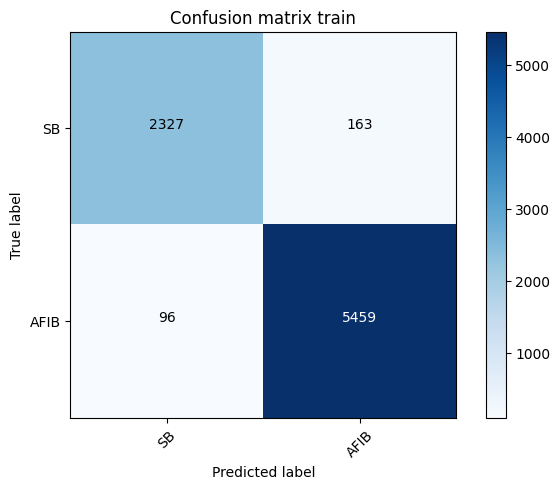

In [62]:
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')

Confusion matrix, without normalization
[[ 939   89]
 [  43 2378]]


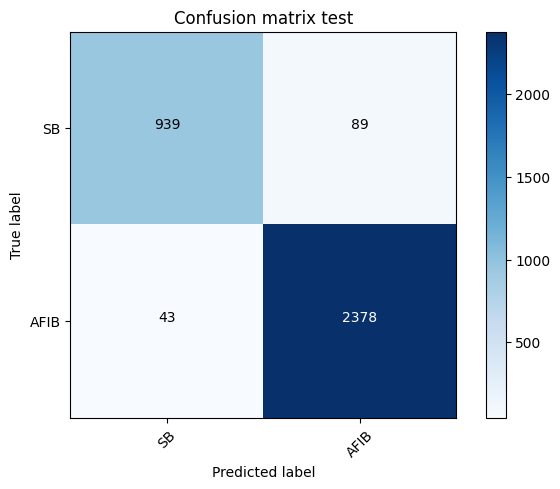

In [63]:
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix test')

Segundo modelo

In [64]:
#Segundo modelo
mlp  = MLPClassifier(
    hidden_layer_sizes=(8, 8, 8, 8, 8),  # Aumento de la cantidad de capas (5 capas)
    activation='relu',  # Función de activación ReLU
    solver='adam',  # Optimizador Adam
    max_iter=1000,  # Número máximo de iteraciones
    alpha=0.0001,  # Regularización L2
    learning_rate_init=0.001,  # Tasa de aprendizaje inicial
    random_state=42
)

print(mlp) 

MLPClassifier(hidden_layer_sizes=(8, 8, 8, 8, 8), max_iter=1000,
              random_state=42)


In [33]:
mlp.fit(X_train, y_train)

# Realizar las predicciones
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)


In [34]:
#%% Results
print(confusion_matrix(y_train,predict_train))

[[2325  165]
 [ 147 5408]]


In [36]:
target_names = ['SB', 'AFIB']
print(classification_report(y_train,predict_train,target_names=target_names))

              precision    recall  f1-score   support

          SB       0.94      0.93      0.94      2490
        AFIB       0.97      0.97      0.97      5555

    accuracy                           0.96      8045
   macro avg       0.96      0.95      0.95      8045
weighted avg       0.96      0.96      0.96      8045



In [37]:
print(confusion_matrix(y_test,predict_test))

[[ 943   85]
 [  63 2358]]


In [38]:
print(classification_report(y_test,predict_test,target_names=target_names))

              precision    recall  f1-score   support

          SB       0.94      0.92      0.93      1028
        AFIB       0.97      0.97      0.97      2421

    accuracy                           0.96      3449
   macro avg       0.95      0.95      0.95      3449
weighted avg       0.96      0.96      0.96      3449



Confusion matrix, without normalization
[[2325  165]
 [ 147 5408]]


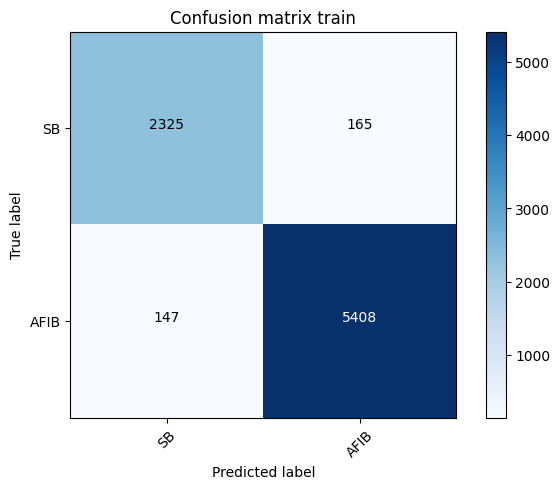

In [40]:
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')


Confusion matrix, without normalization
[[ 943   85]
 [  63 2358]]


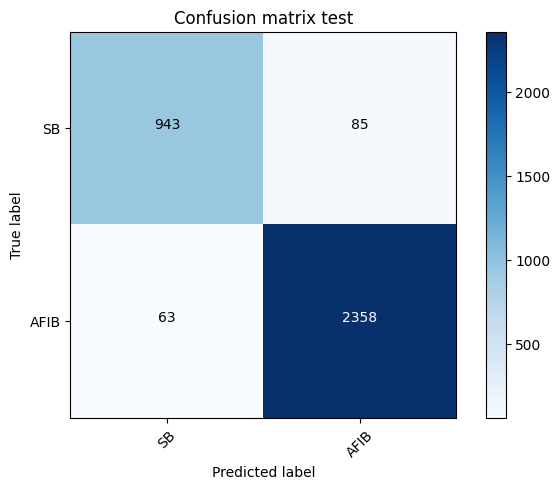

In [41]:
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix test')

Tercer modelo

In [73]:
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 32, 64, 128, 256),  # Aumento de neuronas en capas profundas
    activation='relu',
    solver='adam',
    max_iter=1000,
    alpha=0.0001,
    learning_rate_init=0.001,
    random_state=42
)

print(mlp) 

MLPClassifier(hidden_layer_sizes=(16, 32, 64, 128, 256), max_iter=1000,
              random_state=42)


In [74]:
mlp.fit(X_train, y_train)

# Realizar las predicciones
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

In [75]:
#%% Results
print(confusion_matrix(y_train,predict_train))

[[2423   67]
 [  66 5489]]


In [76]:
target_names = ['SB', 'AFIB']
print(classification_report(y_train,predict_train,target_names=target_names))

              precision    recall  f1-score   support

          SB       0.97      0.97      0.97      2490
        AFIB       0.99      0.99      0.99      5555

    accuracy                           0.98      8045
   macro avg       0.98      0.98      0.98      8045
weighted avg       0.98      0.98      0.98      8045



In [77]:
print(confusion_matrix(y_test,predict_test))

[[ 969   59]
 [  48 2373]]


In [78]:
print(classification_report(y_test,predict_test,target_names=target_names))

              precision    recall  f1-score   support

          SB       0.95      0.94      0.95      1028
        AFIB       0.98      0.98      0.98      2421

    accuracy                           0.97      3449
   macro avg       0.96      0.96      0.96      3449
weighted avg       0.97      0.97      0.97      3449



Confusion matrix, without normalization
[[2423   67]
 [  66 5489]]


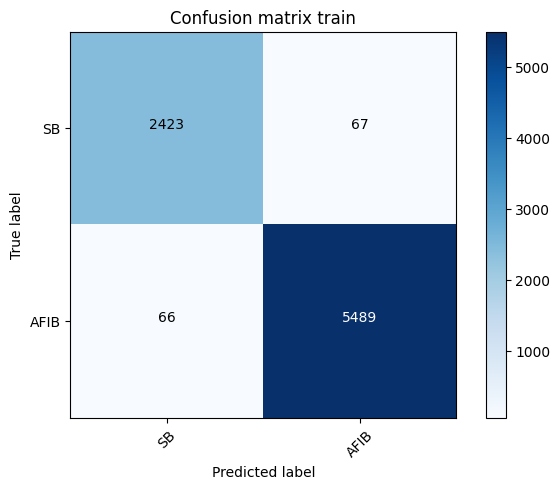

In [79]:
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')

Confusion matrix, without normalization
[[ 969   59]
 [  48 2373]]


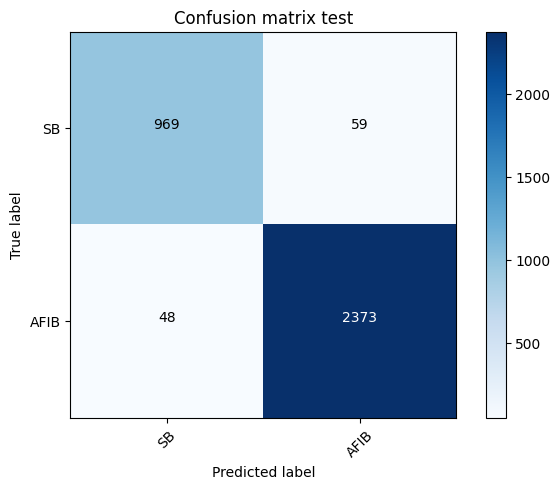

In [80]:
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix test')

Cuarto Modelo

In [81]:
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32, 16),  # Más neuronas al inicio y menos hacia el final
    activation='relu',
    solver='adam',
    max_iter=1000,
    alpha=0.0001,
    learning_rate_init=0.001,
    random_state=42
)

print(mlp) 


MLPClassifier(hidden_layer_sizes=(128, 64, 32, 16), max_iter=1000,
              random_state=42)


In [82]:
mlp.fit(X_train, y_train)

# Realizar las predicciones
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)



In [83]:
#%% Results
print(confusion_matrix(y_train,predict_train))

[[2417   73]
 [  37 5518]]


In [84]:
target_names = ['SB', 'AFIB']
print(classification_report(y_train,predict_train,target_names=target_names))

              precision    recall  f1-score   support

          SB       0.98      0.97      0.98      2490
        AFIB       0.99      0.99      0.99      5555

    accuracy                           0.99      8045
   macro avg       0.99      0.98      0.98      8045
weighted avg       0.99      0.99      0.99      8045



In [85]:
print(confusion_matrix(y_test,predict_test))

[[ 964   64]
 [  37 2384]]


In [86]:
print(classification_report(y_test,predict_test,target_names=target_names))

              precision    recall  f1-score   support

          SB       0.96      0.94      0.95      1028
        AFIB       0.97      0.98      0.98      2421

    accuracy                           0.97      3449
   macro avg       0.97      0.96      0.96      3449
weighted avg       0.97      0.97      0.97      3449



Confusion matrix, without normalization
[[2417   73]
 [  37 5518]]


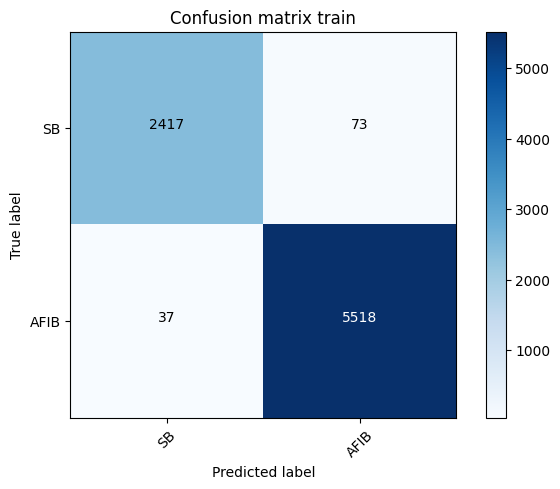

In [87]:
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')

Confusion matrix, without normalization
[[ 964   64]
 [  37 2384]]


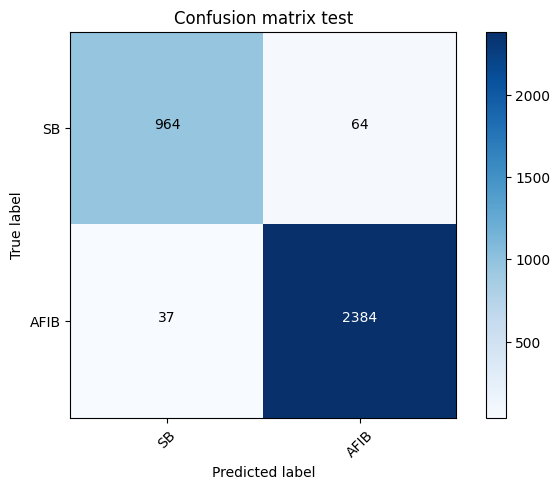

In [88]:
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix test')

8. Consultar cómo funciona, realizar y discutir un ejemplo con los datos, del algoritmo de K means (10%) y máquinas de soporte vectorial (SVM) (10%)

El algoritmo K-means[1] utiliza el concepto de clustering, el cual es una herramienta para segmentar datos con características similares entre sí pero diferentes a otros grupos. El objetivo del K-mean es agrupar observaciones similares para descubrir patrones mediante la reducción de la suma de las distancias de los datos con el centroide, lo hace mediante un número fijo de clusters (k) en el dataset
Funcionamiento del Algoritmo K-Means en Pasos Cortos:
1.	Seleccionar el número de clusters (K): Supongamos que queremos dividir un conjunto de datos en 3 grupos.
2.	Inicialización: Elegimos 3 centroides al azar dentro del espacio de datos.
3.	Asignación: Cada punto se asigna al centroide más cercano según la distancia (normalmente la distancia Euclidiana).
4.	Actualización: Se recalculan los centroides promediando las posiciones de los puntos asignados a cada cluster.
5.	Repetir: Los pasos de asignación y actualización se repiten hasta que los centroides no cambien más o se alcance un número máximo de iteraciones.

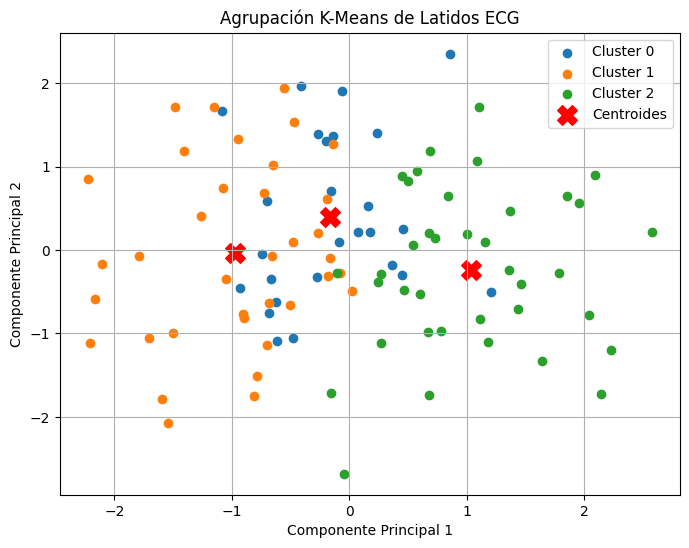

Centroides de los Clusters:
[[-0.24669564 -1.11833603  0.49443257  0.02901031]
 [-0.07946522 -0.01046958 -0.94021437 -0.57199137]
 [ 0.24407459  0.77509584  0.55243343  0.5220374 ]]

Etiquetas de los Latidos:
[1 1 2 2 2 2 0 0 0 2 2 1 1 0 0 0 0 2 2 1 1 2 0 1 0 2 0 0 1 2 1 2 0 1 1 1 0
 0 1 2 2 1 2 2 1 1 1 2 0 1 2 2 1 1 0 2 0 0 2 2 1 2 1 2 2 1 2 2 2 0 1 2 1 1
 0 1 0 2 0 1 1 2 1 2 1 0 2 1 0 2 2 2 1 2 1 0 2 1 0 1]


In [90]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Simulación de datos de ECG (Reemplaza esto con tus datos reales)
# Suponemos que 'X' contiene las características extraídas del ECG (amplitud, duración, intervalos, etc.)
# Ejemplo ficticio de datos: 100 muestras con 4 características (amplitud de onda P, QRS, T y duración del intervalo RR)
X = np.random.rand(100, 4) * 100  # Datos ficticios (100 muestras, 4 características)

# Escalado de datos para normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicación del algoritmo K-Means
num_clusters = 3  # Definir el número de clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_scaled)

# Obtener etiquetas de los clusters
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Visualización utilizando PCA para reducir dimensiones a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Graficar los clusters
plt.figure(figsize=(8, 6))
for cluster in range(num_clusters):
    plt.scatter(X_pca[labels == cluster, 0], X_pca[labels == cluster, 1], label=f'Cluster {cluster}')
plt.scatter(pca.transform(centroids)[:, 0], pca.transform(centroids)[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title('Agrupación K-Means de Latidos ECG')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir resultados
print("Centroides de los Clusters:")
print(centroids)
print("\nEtiquetas de los Latidos:")
print(labels)

Support vector machine (SVM) es un algoritmo de aprendizaje supervisado que se utiliza en muchos problemas de clasificación y regresión. El objetivo del algoritmo SVM es encontrar un hiperplano que separe de la mejor forma posible dos clases diferentes de puntos de datos. “De la mejor forma posible” implica el hiperplano con el margen más amplio entre las dos clases, representado por los signos más y menos en la siguiente figura. El margen se define como la anchura máxima de la región paralela al hiperplano que no tiene puntos de datos interiores. El algoritmo solo puede encontrar este hiperplano en problemas que permiten separación lineal; en la mayoría de los problemas prácticos, el algoritmo maximiza el margen flexible permitiendo un pequeño número de clasificaciones erróneas.
![Img_2](./Img_2.jpg)

Clasificación Report:
              precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.36      0.71      0.48         7

    accuracy                           0.45        20
   macro avg       0.51      0.51      0.45        20
weighted avg       0.56      0.45      0.44        20

Matriz de Confusión:
[[4 9]
 [2 5]]


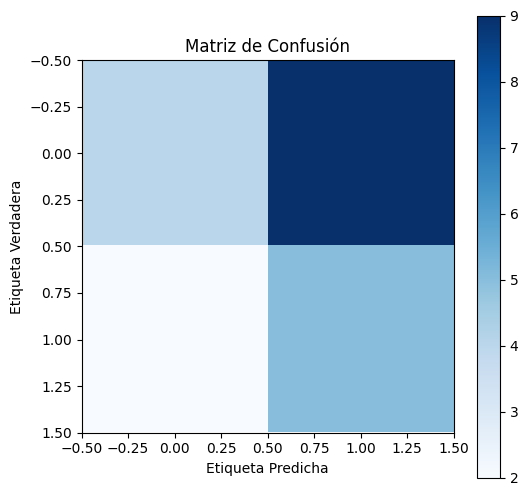

In [89]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Cargar tus datos ECG (suponiendo que tienes un DataFrame con características y etiquetas)
# Aquí, 'ecg_data.csv' es el archivo que contiene los datos de ECG, y 'label' son las etiquetas (normal/anormal)
# Ajusta la ruta y nombre del archivo según sea necesario
# df = pd.read_csv('ruta/a/tu/archivo/ecg_data.csv')

# Supongamos que 'X' son las características del ECG y 'y' las etiquetas (0 = normal, 1 = anormal)
# Por ejemplo, podríamos tener 'X' con características extraídas como amplitudes, intervalos, duraciones, etc.
# df = pd.DataFrame(...)  # Cargar o procesar datos reales

# Ejemplo de datos ficticios
# X = características extraídas del ECG (por ejemplo, amplitudes, duraciones)
# y = etiquetas correspondientes (0 = normal, 1 = anormal)
X = np.random.randn(100, 5)  # Datos de ejemplo (100 muestras, 5 características)
y = np.random.choice([0, 1], size=100)  # Etiquetas aleatorias (0 = normal, 1 = anormal)

# Dividir el conjunto de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar las características para mejorar el rendimiento de SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar el clasificador SVM con kernel RBF
svm_model = SVC(kernel='rbf', C=1, gamma='scale')  # 'C' controla la regularización, 'gamma' controla el kernel RBF

# Entrenar el modelo con los datos de entrenamiento
svm_model.fit(X_train_scaled, y_train)

# Realizar predicciones en los datos de prueba
y_pred = svm_model.predict(X_test_scaled)

# Evaluar el modelo
print("Clasificación Report:")
print(classification_report(y_test, y_pred))  # Reporte de precisión, recall, f1-score

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))  # Matriz de confusión para ver los verdaderos positivos, negativos, etc.

# Graficar la matriz de confusión
plt.figure(figsize=(6, 6))
plt.imshow(confusion_matrix(y_test, y_pred), interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

9. Consultar por lo menos tres equipos comerciales traen ya incorporados algoritmos de ayuda diagnóstica a partir de señales EKG (5%) y discutir brevemente las funcionalidades desde la teoría vista en el curso (5%)

1. Electrocardiógrafo con interpretación automática:
Este equipo registra la actividad eléctrica del corazón y, a través de algoritmos avanzados, proporciona una interpretación inicial del electrocardiograma (ECG).
Los electrodos colocados en el cuerpo captan las señales eléctricas del corazón, que luego son digitalizadas y procesadas por el equipo. Los algoritmos analizan la forma, duración y frecuencia de las ondas del ECG para identificar patrones característicos de diferentes arritmias, bloqueos, hipertrofias y otras alteraciones cardiacas. La interpretación automática ofrece un diagnóstico preliminar, pero siempre debe ser corroborado por un médico.

2. Monitor de paciente con análisis de ECG en tiempo real:
Este equipo monitorea continuamente las constantes vitales de un paciente, incluyendo el ECG. Los algoritmos analizan la señal en tiempo real para detectar cambios significativos que puedan indicar el desarrollo de arritmias o isquemia miocárdica.
Los electrodos se adhieren al cuerpo del paciente y transmiten las señales a un monitor central. Los algoritmos procesan la señal en busca de patrones anormales y generan alarmas visuales y audibles cuando se detectan eventos críticos. Estos monitores son utilizados en unidades de cuidados intensivos, quirófanos y otros entornos hospitalarios.

3. Holter con análisis de arritmias:
El Holter es un dispositivo portátil que registra el ECG durante un período prolongado (24 horas o más). Los algoritmos analizan el registro para detectar arritmias intermitentes que pueden no ser evidentes en un ECG convencional.
El paciente lleva el Holter durante el período de registro y realiza sus actividades habituales. Al finalizar el registro, los datos se descargan en una computadora y los algoritmos analizan la señal en busca de eventos arrítmicos. El cardiólogo interpreta los resultados y emite un informe.

4. Desfibrilador automático implantable (DAI):
El DAI es un dispositivo implantado en el pecho de pacientes con alto riesgo de arritmias ventriculares mortales. El DAI monitorea continuamente el ritmo cardiaco y, en caso de detectar una taquicardia ventricular o fibrilación ventricular, emite una descarga eléctrica para restablecer el ritmo normal.
Los electrodos del DAI están en contacto directo con el corazón y detectan las señales eléctricas. Los algoritmos analizan la señal en tiempo real y desencadenan la descarga eléctrica cuando es necesario.

5. Relojes inteligentes con ECG:
Algunos relojes inteligentes incorporan sensores capaces de registrar un ECG de una sola derivación. Los algoritmos analizan la señal para detectar arritmias como la fibrilación auricular.
El usuario coloca el dedo sobre el sensor del reloj y la aplicación asociada procesa la señal. La detección de fibrilación auricular se basa en el análisis de la variabilidad de la frecuencia cardíaca y otros parámetros.
Consideraciones desde el punto de vista de un curso de bioseñales:

Adquisición de la señal: La calidad de la señal EKG es fundamental para el correcto funcionamiento de los algoritmos. Los artefactos y el ruido pueden afectar significativamente la precisión del diagnóstico.
Preprocesamiento de la señal: Los algoritmos de preprocesamiento son utilizados para eliminar el ruido, filtrar la señal y normalizarla.
Extracción de características: A partir de la señal preprocesada, se extraen características relevantes como la frecuencia cardíaca, el intervalo QT, la amplitud de las ondas y otros parámetros.
Clasificación: Los algoritmos de clasificación utilizan las características extraídas para determinar si la señal corresponde a un ritmo cardiaco normal o patológico.
Interpretación: La interpretación de los resultados obtenidos por los algoritmos debe ser realizada por un médico, ya que los equipos no pueden reemplazar la experiencia clínica.

La calidad de la señal ECG es un factor crítico para el correcto funcionamiento de los algoritmos en dispositivos médicos, ya que artefactos y ruido pueden comprometer significativamente la precisión del diagnóstico. En el curso de bioseñales, se subraya la importancia de comprender cómo estas señales son afectadas por interferencias externas, movimientos del paciente y limitaciones en los sensores, aspectos clave para mejorar la adquisición de datos en dispositivos médicos. El proceso comienza con el preprocesamiento de la señal, donde se utilizan técnicas avanzadas de eliminación de ruido, filtrado y normalización para garantizar que la señal sea lo suficientemente clara y consistente para el análisis posterior. Este paso es esencial para que los algoritmos puedan trabajar con datos confiables, un concepto central en el diseño de dispositivos biomédicos.

A partir de la señal preprocesada, se extraen características relevantes, como la frecuencia cardíaca, el intervalo QT y la amplitud de las ondas, entre otros parámetros. En un curso de bioseñales, estas características se estudian en detalle para entender cómo se relacionan con condiciones fisiológicas y patológicas del corazón. Los algoritmos de clasificación, utilizando estas características, determinan si la señal corresponde a un ritmo cardíaco normal o patológico, lo que permite a los dispositivos emitir alertas automatizadas o guiar diagnósticos preliminares. Sin embargo, aunque estas herramientas son poderosas, en bioseñales también se enfatiza que la interpretación de los resultados debe recaer en un médico capacitado, ya que los equipos no pueden reemplazar la experiencia clínica.

Este enfoque integral, que combina la adquisición, preprocesamiento, extracción de características, clasificación e interpretación, es un ejemplo de cómo los principios enseñados en un curso de bioseñales se aplican directamente al desarrollo y funcionamiento de dispositivos médicos avanzados, mejorando tanto la precisión diagnóstica como la seguridad del paciente.

# Referencias

[1] Sanz, F. (2024, 6 julio). Algoritmo K-Means Clustering – aplicaciones y desventajas. The Machine Learners. https://www.themachinelearners.com/k-means/